Load up necessary libraries

In [1]:
#Persistence Filter files
from libpython_persistence_filter import *
from libpython_persistence_filter_utils import *
from persistence_filter_test_utils import *

#Python scientific computing stuffs
from numpy import *
from scipy.stats import *
from matplotlib.pyplot import *
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

#Settings for rendering TeX in MATLAB
rc('text', usetex=True)

#Plotting options
fig_scaling = .5  #Scaling factor for figures
figure_size = (fig_scaling * 8.0, fig_scaling*6.0)  #Figure size, in inches
figure_folder = 'figures/'  #The folder in which to save the output


Configure simulation options

In [2]:
#PERSISTENCE FILTER SETTINGS
#Admissible range of lambdas for use with general-purpose prior
lambda_u = 1
lambda_l = .001

#General-purpose prior log-survival time
gp_logS = lambda x : log_general_purpose_survival_function(x, lambda_l, lambda_u)

#Uniform prior log-survival time
simulation_length = 1000 #Length of simulation in seconds
uniform_logS = lambda x : asscalar(where(logical_and(0<= x, x <= simulation_length), 
                                log(subtract(1.0, (1.0 / simulation_length)*x)), 0.0))

In [3]:
#DATA GENERATION SETTINGS


#"Standard" simulation settings
P_M_standard = .1  #Standard missed detection probability
P_F_standard = .1 #Standard false alarm probability
lambda_r_standard = 1.0 / 50.0  #Standard revisitation rate
lambda_o = 1.0  #Inter-observation rate
p_N = 1.0 / 5.0  #p_N = probability of leaving after the last reobservation; expected # observations N = 1 / p_N


#Sets of parameter settings to test

#Sets of error rates to test
P_M_test = [.01, .05, .1, .15, .20, .25, .30, .35, .40]
P_F_test = [.01, .05, .1, .15, .20, .25, .30, .35, .40]

#Sets of revisitation rates to test
lambda_r_test = [1. / 100., 1. / 50., 1. / 25., 1. / 10., 1. / 5.]

num_instances_per_setting = 100  #Number of Monte Carlo samples to draw for each parameter setting


#The set of times to query the belief of the persistence filter
query_times = arange(0, simulation_length, .1)

TEST #1:  Varying the detector error rates, evaluating using average L1 error

In [4]:
%%time

#Allocate output storage array
gp_persistence_filter_detector_avg_MAE_errors = empty((len(P_M_test), len(P_F_test)))
uniform_persistence_filter_detector_avg_MAE_errors = empty((len(P_M_test), len(P_F_test)))
empirical_estimator_detector_avg_MAE_errors = empty((len(P_M_test), len(P_F_test)))

gp_persistence_filter_instance_errors = empty(num_instances_per_setting)
uniform_persistence_filter_instance_errors = empty(num_instances_per_setting)
empirical_estimator_instance_errors = empty(num_instances_per_setting)

for i in range(len(P_M_test)):
    P_M = P_M_test[i]
    for j in range(len(P_F_test)):
        P_F = P_F_test[j]
        for t in range(num_instances_per_setting):
            
            #Uniformly randomly sample a survival time
            survival_time = random.uniform(0, simulation_length)   
        
            #Sample observation times
            observation_times = sample_observation_times(lambda_r_standard, lambda_o, p_N, simulation_length)
            
            #Sample observations
            Y_binary = generate_observations(survival_time, observation_times, P_M, P_F)
            Y_bool = Y_binary > 0
            
            #Run the general-purpose peristence filter
            gp_persistence_filter_belief = run_persistence_filter(Y_bool, observation_times, P_M, P_F, query_times, gp_logS)
            
            #Run the uniform persistence filter
            uniform_persistence_filter_belief = run_persistence_filter(Y_bool, observation_times, P_M, P_F, query_times, uniform_logS)
            
            #Run the empirical estimator
            empirical_estimator_belief = run_empirical_estimator(Y_bool, observation_times, query_times)
            
            #Compute the errors
            X_t = query_times <= survival_time  #Ground truth
            gp_persistence_filter_instance_errors[t] = compute_mean_absolute_error(X_t, gp_persistence_filter_belief, query_times)
            uniform_persistence_filter_instance_errors[t] = compute_mean_absolute_error(X_t, uniform_persistence_filter_belief, query_times)
            empirical_estimator_instance_errors[t] = compute_mean_absolute_error(X_t, empirical_estimator_belief, query_times)
            
        #Compute the means of the MAE errors for these parameter settings
        gp_persistence_filter_detector_avg_MAE_errors[i,j] = mean(gp_persistence_filter_instance_errors)
        uniform_persistence_filter_detector_avg_MAE_errors[i,j] = mean(uniform_persistence_filter_instance_errors)
        empirical_estimator_detector_avg_MAE_errors[i,j] = mean(empirical_estimator_instance_errors)

CPU times: user 24min 35s, sys: 571 ms, total: 24min 36s
Wall time: 24min 35s


Plotting options

In [5]:
contour_levels = linspace(0.0, .5, 100)  # Use the same contour levels for all plots
ticks = linspace(0, .5, 6)  # Set of colorbar tick marks


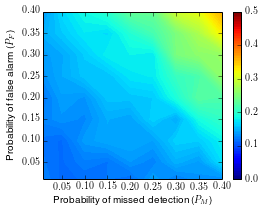

In [15]:
figure(figsize=figure_size)
contourf(P_M_test, P_F_test, gp_persistence_filter_detector_avg_MAE_errors, contour_levels)
#title('General-purpose persistence filter mean absolute error')
xlabel('Probability of missed detection ($P_M$)')
ylabel('Probability of false alarm ($P_F$)')
cbar = colorbar(ticks = ticks)
#savefig(figure_folder + 'general_purpose_persistence_filter_L1_error_vs_detector_error_rates.pdf', bbox_inches='tight')
show()

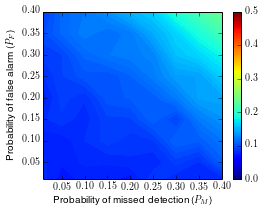

In [16]:
figure(figsize=figure_size)
contourf(P_M_test, P_F_test, uniform_persistence_filter_detector_avg_MAE_errors, contour_levels)
#title('Uniform prior persistence filter mean absolute error')
xlabel('Probability of missed detection ($P_M$)')
ylabel('Probability of false alarm ($P_F$)')
cbar = colorbar(ticks = ticks)
#savefig(figure_folder + 'uniform_persistence_filter_L1_error_vs_detector_error_rates.pdf', bbox_inches='tight')
show()

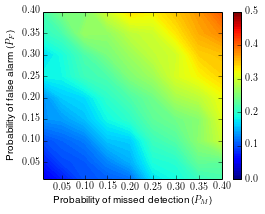

In [17]:
figure(figsize=figure_size)
contourf(P_M_test, P_F_test, empirical_estimator_detector_avg_MAE_errors, contour_levels)
#title('Empirical estimator mean absolute error')
xlabel('Probability of missed detection ($P_M$)')
ylabel('Probability of false alarm ($P_F$)')
cbar = colorbar(ticks = ticks)
#savefig(figure_folder + 'empirical_estimator_L1_error_vs_detector_error_rates.pdf', bbox_inches='tight')
show()

TEST #2:  Varying the revisitation rates, evaluating using average L1 error

In [18]:
%%time

#Allocate output storage array
gp_persistence_filter_revisit_rate_avg_MAE_errors = empty(len(lambda_r_test))
uniform_persistence_filter_revisit_rate_avg_MAE_errors = empty(len(lambda_r_test))
empirical_estimator_revisit_rate_avg_MAE_errors = empty(len(lambda_r_test))

gp_persistence_filter_instance_errors = empty(num_instances_per_setting)
uniform_persistence_filter_instance_errors = empty(num_instances_per_setting)
empirical_estimator_instance_errors = empty(num_instances_per_setting)

for l in range(len(lambda_r_test)):
    lambda_r = lambda_r_test[l]
    for t in range(num_instances_per_setting):

        #Uniformly randomly sample a survival time
        survival_time = random.uniform(0, simulation_length)   
        
        #Sample observation times
        observation_times = sample_observation_times(lambda_r, lambda_o, p_N, simulation_length)
        
        #Sample observations
        Y_binary = generate_observations(survival_time, observation_times, P_M_standard, P_F_standard)
        Y_bool = Y_binary > 0
            
        #Run the general-purpose peristence filter
        gp_persistence_filter_belief = run_persistence_filter(Y_bool, observation_times, P_M_standard, P_F_standard, query_times, gp_logS)
        
        #Run the uniform-prior peristence filter
        uniform_persistence_filter_belief = run_persistence_filter(Y_bool, observation_times, P_M_standard, P_F_standard, query_times, uniform_logS)
        
        
        #Run the empirical estimator
        empirical_estimator_belief = run_empirical_estimator(Y_bool, observation_times, query_times)
            
        #Compute the errors
        X_t = query_times <= survival_time  #Ground truth
        gp_persistence_filter_instance_errors[t] = compute_mean_absolute_error(X_t, gp_persistence_filter_belief, query_times)   
        uniform_persistence_filter_instance_errors[t] = compute_mean_absolute_error(X_t, uniform_persistence_filter_belief, query_times)            
        empirical_estimator_instance_errors[t] = compute_mean_absolute_error(X_t, empirical_estimator_belief, query_times)
            
        #Compute the means of the MAE errors for these parameter settings
    gp_persistence_filter_revisit_rate_avg_MAE_errors[l] = mean(gp_persistence_filter_instance_errors)
    uniform_persistence_filter_revisit_rate_avg_MAE_errors[l] = mean(uniform_persistence_filter_instance_errors)
    empirical_estimator_revisit_rate_avg_MAE_errors[l] = mean(empirical_estimator_instance_errors)

CPU times: user 1min 47s, sys: 15.6 ms, total: 1min 47s
Wall time: 1min 47s


Plot output

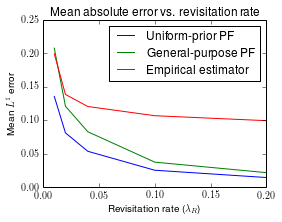

In [19]:
figure(figsize=figure_size)
plot(lambda_r_test, uniform_persistence_filter_revisit_rate_avg_MAE_errors, '-b', label='Uniform-prior PF')
plot(lambda_r_test, gp_persistence_filter_revisit_rate_avg_MAE_errors, '-g', label='General-purpose PF')
plot(lambda_r_test, empirical_estimator_revisit_rate_avg_MAE_errors, '-r', label='Empirical estimator')
title('Mean absolute error vs. revisitation rate')
xlabel('Revisitation rate ($\lambda_R$)')
ylabel('Mean $L^1$ error')
legend()
#savefig(figure_folder + 'Mean_absolute_errors_vs_revisitation_rate.pdf', bbox_inches='tight')
show()